In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
from torchtext import data
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import string
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Using TensorFlow backend.


In [2]:

%matplotlib inline

In [3]:
def generate_trigrams(x):
    res = []
    n_grams = list(zip(*[x[i:] for i in range(3)]))
    for n_gram in n_grams:
        res.append(' '.join(n_gram))
    return res

In [5]:
import spacy

In [6]:
nlp = spacy.load("en_core_web_sm")

In [10]:
import torch
from torchtext import data, datasets
import random

In [12]:
SEED = 1234

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
##############importing imdb daasets#############
TEXT = data.Field(preprocessing=generate_trigrams)
LABEL = data.LabelField(dtype=torch.float)
train_data, test_data = datasets.IMDB.splits(TEXT,LABEL)
print(vars(train_data.examples[0]))
train_data, valid_data = train_data.split(random_state=random.seed(SEED),split_ratio=0.9)
TEXT.build_vocab(train_data)
dictionary = dict(TEXT.vocab.freqs)

{'text': ["I don't know", "don't know who", 'know who could', 'who could find', 'could find fault', 'find fault with', 'fault with a', 'with a simply', 'a simply human', 'simply human and', 'human and funny', 'and funny film', 'funny film like', 'film like this', 'like this with', 'this with lots', 'with lots of', 'lots of delights', 'of delights for', 'delights for your', 'for your heart.', 'your heart. I', 'heart. I enjoyed', 'I enjoyed each', 'enjoyed each minute', 'each minute of', 'minute of it', 'of it and', 'it and guessed', 'and guessed the', 'guessed the ending', 'the ending half', 'ending half way', 'half way through', 'way through the', 'through the movie', 'the movie --', 'movie -- but', '-- but that', 'but that did', 'that did not', 'did not disappoint', 'not disappoint me', 'disappoint me at', 'me at all.', 'at all. It', 'all. It will', 'It will not', 'will not only', 'not only touch', 'only touch your', 'touch your heart', 'your heart but', "heart but it's", "but it's su

In [13]:
markov = pd.DataFrame.from_dict(dictionary,orient="index")
markov = markov.reset_index()
markov.columns = ['trigrams','cnt']
markov['bigram'] =markov.trigrams.apply(lambda x: " ".join(x.split(' ')[:2]))
markov['target'] =markov.trigrams.apply(lambda x: x.split(' ')[2])
inp_cnt = pd.DataFrame(markov.groupby("bigram",as_index=False)["cnt"].sum())

 Change the output appropriately in ‘Simple Sentiment Analysis.ipynb’ to build an LSTM based language model. Plot the training performance as a function of epochs/iterations

In [15]:
SEED = 1234

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

TEXT = data.Field()
LABEL = data.LabelField(dtype=torch.float)

In [16]:
from torchtext import datasets
train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)

In [17]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 25000
Number of testing examples: 25000


In [18]:
print(vars(train_data.examples[0]))
train_data, valid_data = train_data.split(random_state=random.seed(SEED),split_ratio=0.25)

{'text': ['I', "don't", 'know', 'who', 'could', 'find', 'fault', 'with', 'a', 'simply', 'human', 'and', 'funny', 'film', 'like', 'this', 'with', 'lots', 'of', 'delights', 'for', 'your', 'heart.', 'I', 'enjoyed', 'each', 'minute', 'of', 'it', 'and', 'guessed', 'the', 'ending', 'half', 'way', 'through', 'the', 'movie', '--', 'but', 'that', 'did', 'not', 'disappoint', 'me', 'at', 'all.', 'It', 'will', 'not', 'only', 'touch', 'your', 'heart', 'but', "it's", 'such', 'a', 'good', 'family', 'friendly', 'film--we', 'need', 'many', 'more', 'like', 'these!'], 'label': 'pos'}


In [19]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 6250
Number of validation examples: 18750
Number of testing examples: 25000


In [20]:
TEXT.build_vocab(train_data, max_size=1000)
LABEL.build_vocab(train_data)

In [21]:
print(f"Unique tokens in TEXT vocabulary: {len(TEXT.vocab)}")
print(f"Unique tokens in LABEL vocabulary: {len(LABEL.vocab)}")

Unique tokens in TEXT vocabulary: 1002
Unique tokens in LABEL vocabulary: 2


In [23]:
BATCH_SIZE = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size=BATCH_SIZE,
    device=device)

In [24]:
class RNN(nn.Module):
    def __init__(self, input_dim, embedding_dim,BATCH_SIZE,output_dim):
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, output_dim)
        
    def forward(self, x):        
        embedded = self.embedding(x)
        output, (hidden,cell) = self.rnn(embedded)
        dim = output.size()
        output = output.view(-1, output.shape[2])
        output1 = F.log_softmax(output,dim=1)
        
        if BATCH_SIZE==dim[1]:
            output1 = output1.view(-1,OUTPUT_DIM,BATCH_SIZE)
        else:
            output1 = output1.view(dim[1],OUTPUT_DIM,-1)
        #output = [sent len, batch size, hid dim]
        #hidden = [1, batch size, hid dim]       
        return output1

In [25]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
OUTPUT_DIM = len(TEXT.vocab)
model = RNN(INPUT_DIM, EMBEDDING_DIM,BATCH_SIZE,OUTPUT_DIM)

In [26]:
optimizer = optim.SGD(model.parameters(), lr=1e-1)
criterion = nn.NLLLoss()
model = model.to(device)
criterion = criterion.to(device)

In [28]:
def train(model, iterator, optimizer, criterion,BATCH_SIZE):
    
    epoch_loss = 0
    epoch_acc = 0
    epoch_label_count = 0 
    loss=0
    model.train()
    for batch in iterator:
        optimizer.zero_grad()   
        predictions = model(batch.text)

        dim = predictions.size()
        if dim[2] !=BATCH_SIZE:
            BATCH_SIZE = dim[2]
            
        pad = torch.tensor([1]*BATCH_SIZE,device="cuda:0").view(BATCH_SIZE,-1)
        _,preds = torch.max(predictions,1)
        labels = batch.text.view(-1,BATCH_SIZE)
        labels = labels[1:]
        pad = torch.tensor([1]*BATCH_SIZE,device="cuda:0").view(-1,BATCH_SIZE)
        labels = torch.cat((labels,pad),0)
        loss = criterion(predictions,labels)
        acc = torch.sum(preds == labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()
        epoch_label_count+= labels.numel()
        
    return epoch_loss / len(iterator) , (epoch_acc /epoch_label_count)

In [29]:
N_EPOCHS = 10
train_losses = []
valid_losses = []
for epoch in range(N_EPOCHS):
    train_loss,train_acc = train(model, train_iterator, optimizer, criterion,BATCH_SIZE)
    train_losses.append(train_loss)
    print(f'| Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% ')#| Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:.2f}% |')

| Epoch: 01 | Train Loss: 5.949 | Train Acc: 9.33% 
| Epoch: 02 | Train Loss: 5.609 | Train Acc: 9.76% 
| Epoch: 03 | Train Loss: 5.593 | Train Acc: 9.38% 
| Epoch: 04 | Train Loss: 5.597 | Train Acc: 9.03% 
| Epoch: 05 | Train Loss: 5.599 | Train Acc: 8.99% 
| Epoch: 06 | Train Loss: 5.596 | Train Acc: 8.79% 
| Epoch: 07 | Train Loss: 5.597 | Train Acc: 9.14% 
| Epoch: 08 | Train Loss: 5.599 | Train Acc: 8.97% 
| Epoch: 09 | Train Loss: 5.599 | Train Acc: 9.69% 
| Epoch: 10 | Train Loss: 5.593 | Train Acc: 9.26% 


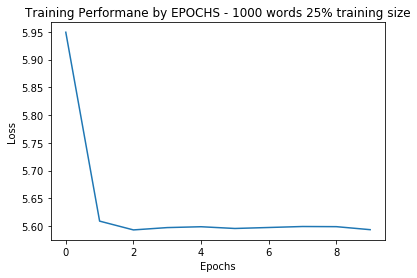

In [30]:
plt.plot(train_losses)
plt.title("Training Performane by EPOCHS - 1000 words 25% training size")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# For each model, describe the key design choices made. Briefly mention how each choice influences training time and generative quality

Markov model we went with the trigrams and there was no difficulty in calculating the probabilities and prediction.

For LSTM there was an input layer followed by embedding then lstm layer. The input was the tokenized text and output also the tokenized text offsetted by 1 place. Ex) if input is {This,is,my,favorite,movie} then output is {is,my,favorite,movie}

We took 25% training data with max 1000 words with batch size 10 to train our lstm model.
If we increased the number of words then the model couldn't be loaded into the gpu as there was insufficient memory
If we increased the training data to higher percentage say 50% or 80% then notebook got disconnected from the server randomly. This error didn't go when we tried to run the code as standalone .py file instead of a python notebook
When we reduced the batch size to 1 then model took longer time to train and when we increased it to 64 then there was memory error once again. We settled at Batch Size 10
Due to this limited training size and words the quality of sentence formed by predicition was affected considerably.The prediction didn't give out a coherent sentence as we would have liked.

# For each model, starting with the phrase ”My favorite movie ”, sample the next few words and create a 20 word generated review

Markov Prediction

In [46]:
def generate_sentence(sentence,no_preds,prediction_length):
    prediction_length -= len(sentence.split(" ")) 
    for j in range(0,no_preds):
        pred_sentence = sentence
        bi = " ".join(pred_sentence.split(" ")[1:])
        for i in range(0,prediction_length):
            poss_pred = np.array(markov.target[markov.bigram==bi])
            scores = np.array(markov.cnt[markov.bigram==bi])
            length = inp_cnt.cnt[inp_cnt.bigram==bi]
            probs = scores/length.iloc[0]
            pred = random.choice(list(enumerate(probs)))[0]
            pred = poss_pred[pred]
            pred_sentence = pred_sentence + " " + pred
            bi = " ".join([bi.split(" ")[1],pred])
        pred_length = len(pred_sentence.split(sep=' '))
        print(f"Generated Review {str(j+1)}: ({pred_length}) {pred_sentence}\n")
generate_sentence("my favorite movie",5,20)

Generated Review 1: (20) my favorite movie Dawn of the cave the siblings intended to fool Coburn with PAT GARRETT & BILLY THE KID

Generated Review 2: (20) my favorite movie (next to Ranma)... and probably saying hello to Oshii's creation "superlivemation": not quite at the worlds described

Generated Review 3: (20) my favorite movie growing up, you can drive Grandpa's car. He can't trust anyone for a self-confessed b-grade horror) and

Generated Review 4: (20) my favorite movie he plays Wilhelm Grimm, a sad day in time. We never learn his true colors--enslaving women, oppressing

Generated Review 5: (20) my favorite movie at all!<br /><br />He falls victim to stereotypical male vs. female characters here are better played, and



In [44]:
for j in range(5):
    inp =torch.tensor([[TEXT.vocab.stoi["my"]],[TEXT.vocab.stoi["favorite"]],[TEXT.vocab.stoi["movie"]]],device="cuda:0")
    for i in range(16):
        op = model(inp)
        op = op.squeeze(0)
        op = op[:,op.size()[1]-1].detach().cpu().numpy()
        op = np.sort(op)[::-1]
        op = op[:500] 
        new_inp = torch.tensor(np.where(op==np.random.choice(op,1)),device="cuda:0")
        inp = torch.cat((inp,new_inp))
    
    generated_text = ""
    for val in inp:
        generated_text = generated_text + " " + TEXT.vocab.itos[val]
    gen_length = len(generated_text.split(sep=' '))
    print(f"Generated Review {str(j+1)}: ({gen_length}) {generated_text}\n")

Generated Review 1: (20)  my favorite movie looking (and seeing I me I My films between least While course American give there nothing

Generated Review 2: (20)  my favorite movie favorite all might last only lot once times stupid around looking as short old acting worth

Generated Review 3: (20)  my favorite movie between women as time such performance Of someone school For one DVD able person At point

Generated Review 4: (20)  my favorite movie very help lot time never movie The To goes isn't father enjoyed definitely />I though classic

Generated Review 5: (20)  my favorite movie film, movies His will pretty gave find TV most To father quite on life several that

